In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import matplotlib.dates as mdates

from google.colab import drive
drive.mount('/content/gdrive')

path = '/content/gdrive/MyDrive/Colab_Notebooks/FYP/'

In [ ]:
# Read csv
full_training_data = pd.read_csv(path+'/data/full_training_data_10y.csv',index_col=False)

In [ ]:
#Min-Max scaling
min_max_column = ['Open', 'High', 'Low', 'Volume']

mms_X = MinMaxScaler()
full_training_data[min_max_column] = mms_X.fit_transform(full_training_data[min_max_column])

mms_y = MinMaxScaler()
full_training_data['Adj Close'] = mms_y.fit_transform(full_training_data[['Adj Close']])

In [ ]:
# Feature selection
regression_vanilla_column = ['Open', 'High', 'Low', 'Volume', 'Adj Close']
regression_vanilla_df = full_training_data[regression_vanilla_column]

In [ ]:
# Create dataset for sequential input
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    num = dataset.shape[1] - 1
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :-1]
        dataX.append(a)
        dataY.append(dataset[i + look_back, num])
    return np.array(dataX), np.array(dataY)

In [ ]:
# Training
np.random.seed(7)
regression_vanilla_df_values = regression_vanilla_df.values
look_back = 10

def train(regression_df_values):
  train_size = int(len(regression_df_values) * 0.7)
  val_size = int(len(regression_df_values) * 0.15)
  test_size = len(regression_df_values) - train_size - val_size
  train, val, test = regression_df_values[0:train_size+1, :], regression_df_values[train_size:train_size+val_size+1, :], regression_df_values[train_size+val_size:len(regression_df_values)+1, :]
  num = train.shape[1]-1

  trainX, trainY = create_dataset(train, look_back)
  valX, valY = create_dataset(val, look_back)
  testX, testY = create_dataset(test, look_back)
  trainX = np.reshape(trainX, (trainX.shape[0], look_back, num))
  valX = np.reshape(valX, (valX.shape[0], look_back, num))
  testX = np.reshape(testX, (testX.shape[0],look_back, num))

  model=Sequential()
  model.add(LSTM(1024,input_shape=(look_back,num)))
  model.add(Dense(1))
  optimizer = Adam(lr=0.01)
  model.compile(loss='mean_squared_error', optimizer=optimizer)
  model.summary()

  model.fit(trainX, trainY, validation_data=(valX, valY), epochs=20, batch_size=64, verbose=1)
  train_predict=model.predict(trainX)
  val_predict=model.predict(valX)
  test_predict=model.predict(testX)

  # Return original value
  trainY = mms_y.inverse_transform(np.array(trainY).reshape(1, -1))[0]
  valY = mms_y.inverse_transform(np.array(valY).reshape(1, -1))[0]
  testY = mms_y.inverse_transform(np.array(testY).reshape(1, -1))[0]
  train_predict = mms_y.inverse_transform(np.array(train_predict).reshape(1, -1))[0]
  val_predict = mms_y.inverse_transform(np.array(val_predict).reshape(1, -1))[0]
  test_predict = mms_y.inverse_transform(np.array(test_predict).reshape(1, -1))[0]

  # Calculate root mean squared error
  rmse_train = np.sqrt(mean_squared_error(trainY, train_predict))
  rmse_val = np.sqrt(mean_squared_error(valY, val_predict))
  rmse_test = np.sqrt(mean_squared_error(testY, test_predict))

  # Calculate MAPE
  mape_train = mean_absolute_percentage_error(trainY, train_predict)
  mape_val = mean_absolute_percentage_error(valY, val_predict)
  mape_test = mean_absolute_percentage_error(testY, test_predict)

  # Calculate R2 score
  r2_train = r2_score(trainY, train_predict)
  r2_val = r2_score(valY, val_predict)
  r2_test = r2_score(testY, test_predict)

  print(f"RMSE on training set: {rmse_train:.2f}")
  print(f"RMSE on validation set: {rmse_val:.2f}")
  print(f"RMSE on testing set: {rmse_test:.2f}")
  print(f"MAPE on training set: {mape_train:.2f}")
  print(f"MAPE on validation set: {mape_val:.2f}")
  print(f"MAPE on testing set: {mape_test:.2f}")
  print(f"R2 score on training set: {r2_train:.2f}")
  print(f"R2 score on validation set: {r2_val:.2f}")
  print(f"R2 score on testing set: {r2_test:.2f}")

  return train, val, test, trainY, valY, testY, train_predict, val_predict, test_predict, train_size, val_size, test_size

In [ ]:
# Plot the results
def plot_graph(trainY, valY, testY, y_pred_train, y_pred_val, y_pred_test, train_size, val_size, test_size):

  fig, ax = plt.subplots(figsize=(10, 6))
  ax.plot(full_training_data["Date"], mms_y.inverse_transform(np.array(full_training_data["Adj Close"]).reshape(1, -1))[0], label="Actual Price", color="blue")

  # Sort the training, testing, and validation predictions by date
  train_pred_df = pd.DataFrame({'Date': full_training_data.loc[look_back:train_size-1, 'Date'], 'Predicted': y_pred_train})
  val_pred_df = pd.DataFrame({'Date': full_training_data.loc[train_size+look_back+1:train_size+val_size, 'Date'], 'Predicted': y_pred_val})
  test_pred_df = pd.DataFrame({'Date': full_training_data.loc[train_size+val_size+look_back+1:train_size+val_size+test_size, 'Date'], 'Predicted': y_pred_test})

  # Sort by Date
  train_pred_df = train_pred_df.sort_values(by='Date').reset_index(drop=True)
  val_pred_df = val_pred_df.sort_values(by='Date').reset_index(drop=True)
  test_pred_df = test_pred_df.sort_values(by='Date').reset_index(drop=True)

  result = pd.concat([train_pred_df, val_pred_df])
  result = pd.concat([result, test_pred_df])
  result = result.sort_values(by='Date').reset_index(drop=True)

  # output result
  result.to_csv(path+'lstm_stock_prediction_vanilla.csv', index=False)

  # Scatter Plot for each set of data
  ax.scatter(train_pred_df["Date"], train_pred_df["Predicted"], label="Predicted Price (Train)", color="green", s=10)
  ax.scatter(val_pred_df["Date"], val_pred_df["Predicted"], label="Predicted Price (Val)", color="orange", s=10)
  ax.scatter(test_pred_df["Date"], test_pred_df["Predicted"], label="Predicted Price (Test)", color="red", s=10)

  ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
  ax.set_ylabel("Hang Seng Index Price")
  ax.set_xlabel("Date")
  plt.xticks(rotation=90)
  ax.legend()
  plt.show()

  return None

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 1024)              4214784   
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 4,215,809
Trainable params: 4,215,809
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
33/33 [==============================] - 18s 496ms/step - loss: 0.0188 - val_loss: 0.0011
Epoch 2/20
33/33 [==============================] - 17s 504ms/step - loss: 6.9950e-04 - val_loss: 9.0157e-04
Epoch 3/20
33/33 [==============================] - 17s 507ms/step - loss: 5.5593e-04 - val_loss: 8.2356e-04
Epoch 4/20
33/33 [==============================] - 16s 483ms/step - loss: 5.2736e-04 - val_loss: 8.3396e-04
Epoch 5/20
3

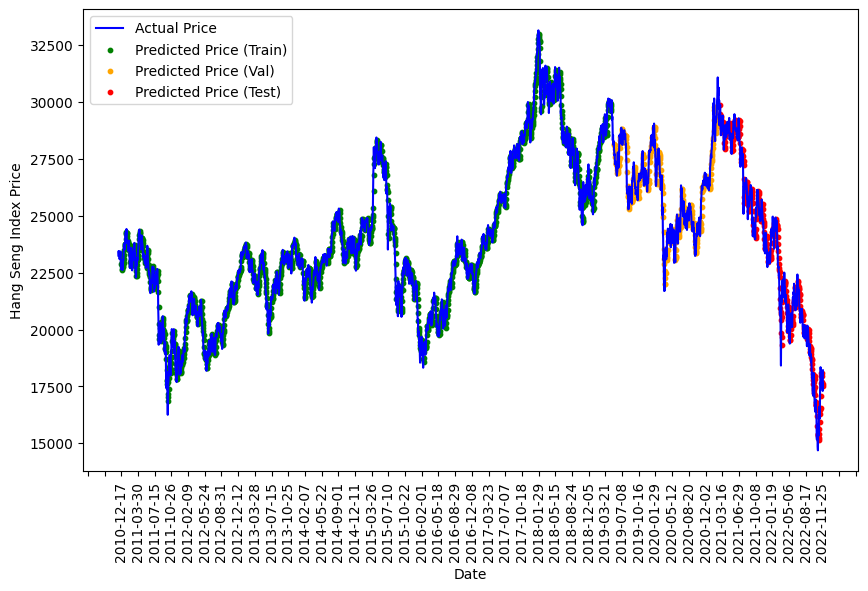

In [ ]:
trainX, valX, testX, trainY, valY, testY, train_predict, val_predict, test_predict, train_size, val_size, test_size = train(regression_vanilla_df_values)
plot_graph(trainY, valY, testY, train_predict, val_predict, test_predict, train_size, val_size, test_size)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1024)              4214784   
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 4,215,809
Trainable params: 4,215,809
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
33/33 [==============================] - 27s 758ms/step - loss: 0.0123 - val_loss: 8.8289e-04
Epoch 2/20
33/33 [==============================] - 27s 819ms/step - loss: 5.7704e-04 - val_loss: 8.3769e-04
Epoch 3/20
33/33 [==============================] - 23s 689ms/step - loss: 5.6007e-04 - val_loss: 8.1457e-04
Epoch 4/20
33/33 [==============================] - 25s 755ms/step - loss: 5.1706e-04 - val_loss: 8.8266e-04
Epoch 5/20

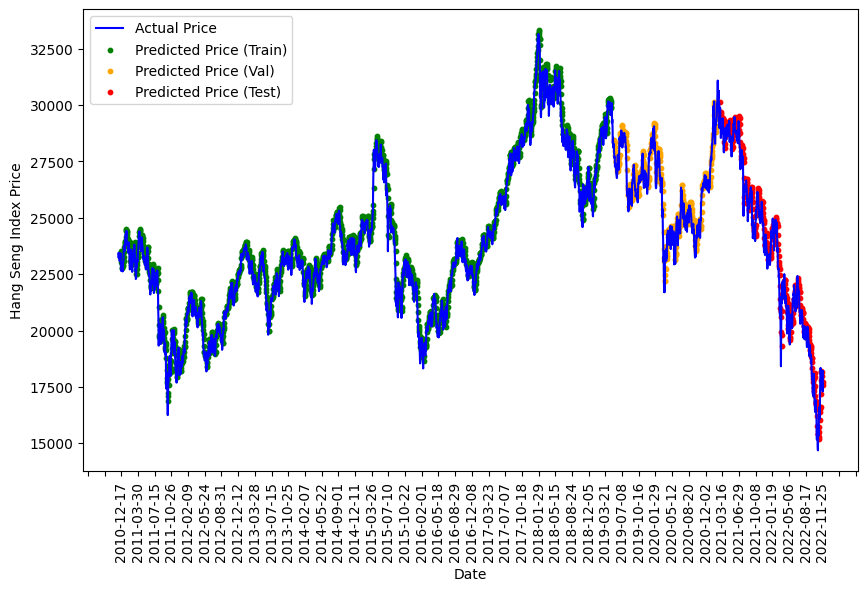

In [ ]:
trainX, valX, testX, trainY, valY, testY, train_predict, val_predict, test_predict, train_size, val_size, test_size = train(regression_vanilla_df_values)
plot_graph(train_predict, val_predict, test_predict, train_size, val_size, test_size)